# Importing Required Libraries 

In [11]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import classification_report
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split

# Loading pretrained model 

In [12]:
# --- Step 1: Load Pretrained RexNet Model ---
class MultiTaskRexNet(nn.Module):
    def __init__(self, backbone):
        super(MultiTaskRexNet, self).__init__()
        self.backbone = backbone
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.age_head = nn.Linear(1920, 101)       # Predict age (0–100)
        self.gender_head = nn.Linear(1920, 2)     # Predict gender (Male, Female)
        self.ethnicity_head = nn.Linear(1920, 5)  # Predict ethnicity (5 classes)

    def forward(self, x):
        features = self.backbone.forward_features(x)
        features = self.global_pool(features).view(features.size(0), -1)
        age_pred = self.age_head(features)
        gender_pred = self.gender_head(features)
        ethnicity_pred = self.ethnicity_head(features)
        return age_pred, gender_pred, ethnicity_pred

# Load pretrained RexNet backbone
def load_pretrained_model(file_path):
    model = timm.create_model('rexnet_150', pretrained=False)
    state_dict = torch.load(file_path, map_location="cpu")
    model.load_state_dict(state_dict, strict=False)
    return MultiTaskRexNet(model)

In [13]:
# File path to pretrained weights
file_path = "/Users/ifeanyinwaneri/Documents/Documents - Ifeanyi’s MacBook Pro/Computer-Vision-Model/face-emotion-recognition/models/pretrained_faces/state_vggface2_rexnet_150.pt"
multi_task_model = load_pretrained_model(file_path)

/var/folders/r0/mdrnq25s5nnb7l0k1pd_89pm0000gn/T/ipykernel_42112/1252606177.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path, map_locat

# Dataset Preparation

In [14]:
# --- Step 2: Dataset Preparation ---
class UTKFaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Parse filenames from UTKFace dataset
def parse_utkface_dataset(dataset_path):
    images, labels = [], []
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg") or filename.endswith(".jpg.chip.jpg"):
            try:
                age, gender, ethnicity = map(int, filename.split("_")[:3])
                images.append(os.path.join(dataset_path, filename))
                labels.append((age, gender, ethnicity))
            except ValueError:
                continue
    return images, labels

In [15]:
# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset path
utkface_path = "/Users/ifeanyinwaneri/Documents/Documents - Ifeanyi’s MacBook Pro/Computer-Vision-Model/CSE-Project Dataset/UTKFace/Aligned&Cropped Faces"
utk_images, utk_labels = parse_utkface_dataset(utkface_path)

# Split into train, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    utk_images, utk_labels, test_size=0.2, random_state=42
)
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

In [16]:
# Create DataLoaders
train_dataset = UTKFaceDataset(train_images, train_labels, transform)
val_dataset = UTKFaceDataset(val_images, val_labels, transform)
test_dataset = UTKFaceDataset(test_images, test_labels, transform)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# Define dataset path
dataset_path = "/Users/ifeanyinwaneri/Documents/Documents - Ifeanyi’s MacBook Pro/Computer-Vision-Model/CSE-Project Dataset/UTKFace/Aligned&Cropped Faces/"

# Parse filenames
def parse_filename(filename):
    parts = filename.split("_")
    age = int(parts[0])
    gender = int(parts[1])
    ethnicity = int(parts[2])
    return age, gender, ethnicity

In [23]:
# Prepare dataset
images = []
labels = []

for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg") or filename.endswith(".jpg.chip.jpg"):
        try:
            age, gender, ethnicity = parse_filename(filename)
            img_path = os.path.join(dataset_path, filename)
            images.append(img_path)
            labels.append((age, gender, ethnicity))
        except ValueError as e:
            print(f"Skipping file due to parsing error: {filename}, Error: {e}")


# Split into train, val, test
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")
print(f"Testing samples: {len(test_images)}")

Skipping file due to parsing error: 39_1_20170116174525125.jpg.chip.jpg, Error: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'
Skipping file due to parsing error: 61_1_20170109150557335.jpg.chip.jpg, Error: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Skipping file due to parsing error: 61_1_20170109142408075.jpg.chip.jpg, Error: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Training samples: 18964
Validation samples: 2370
Testing samples: 2371


In [24]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Extract labels
ages = [label[0] for label in train_labels]
genders = [label[1] for label in train_labels]
ethnicities = [label[2] for label in train_labels]

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Extract labels
ages = [label[0] for label in train_labels]
genders = [label[1] for label in train_labels]
ethnicities = [label[2] for label in train_labels]

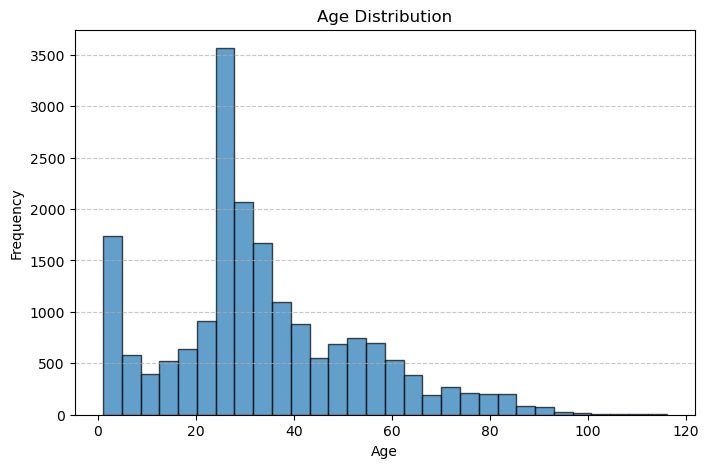

In [25]:
# Function to plot distributions
def plot_distribution(data, title, xlabel, ylabel, bins=None):
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=bins, edgecolor="k", alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Age distribution
plot_distribution(ages, "Age Distribution", "Age", "Frequency", bins=30)

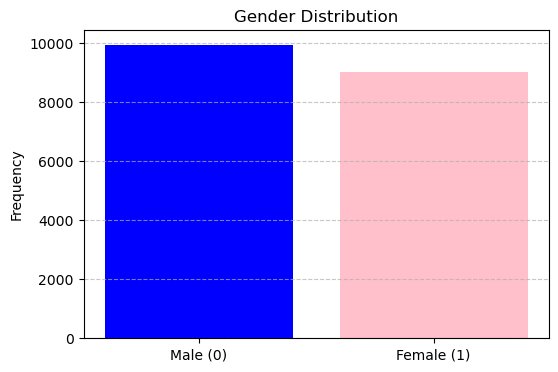

In [26]:
# Gender distribution
gender_counts = Counter(genders)
plt.figure(figsize=(6, 4))
plt.bar(["Male (0)", "Female (1)"], [gender_counts[0], gender_counts[1]], color=["blue", "pink"])
plt.title("Gender Distribution")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

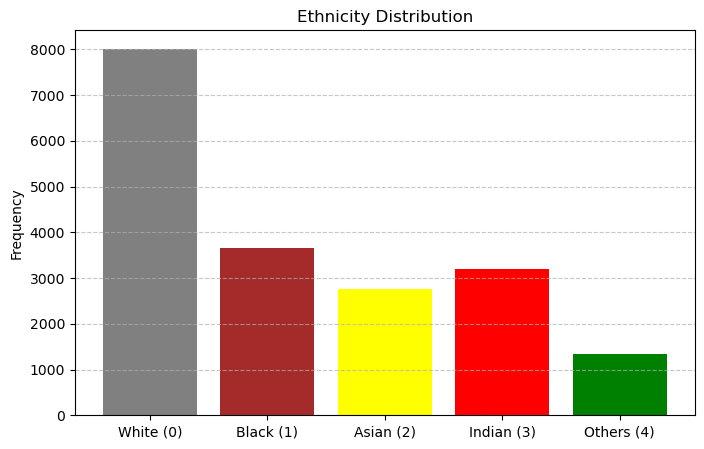

In [27]:
# Ethnicity distribution
ethnicity_counts = Counter(ethnicities)
plt.figure(figsize=(8, 5))
plt.bar(
    ["White (0)", "Black (1)", "Asian (2)", "Indian (3)", "Others (4)"],
    [ethnicity_counts[i] for i in range(5)],
    color=["gray", "brown", "yellow", "red", "green"]
)
plt.title("Ethnicity Distribution")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Training and Validation 

In [17]:
# --- Step 3: Training and Validation ---
# Loss functions
criterion_age = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
criterion_ethnicity = nn.CrossEntropyLoss()

# Optimizer
def create_optimizer(model):
    return optim.Adam([
        {"params": model.age_head.parameters()},
        {"params": model.gender_head.parameters()},
        {"params": model.ethnicity_head.parameters()}
    ], lr=1e-4)

In [18]:
# Training loop
def train_model(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    optimizer = create_optimizer(model)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images = images.to(device)
            age_labels, gender_labels, ethnicity_labels = labels[:, 0], labels[:, 1], labels[:, 2]
            age_labels, gender_labels, ethnicity_labels = age_labels.to(device), gender_labels.to(device), ethnicity_labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            age_preds, gender_preds, ethnicity_preds = model(images)
            loss = (criterion_age(age_preds, age_labels) +
                    criterion_gender(gender_preds, gender_labels) +
                    criterion_ethnicity(ethnicity_preds, ethnicity_labels))
            
            # Backward pass
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")
        validate_model(model, val_loader, device)

In [19]:
# Validation loop
def validate_model(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            age_labels, gender_labels, ethnicity_labels = labels[:, 0], labels[:, 1], labels[:, 2]
            age_labels, gender_labels, ethnicity_labels = age_labels.to(device), gender_labels.to(device), ethnicity_labels.to(device)

            age_preds, gender_preds, ethnicity_preds = model(images)
            val_loss += (criterion_age(age_preds, age_labels).item() +
                         criterion_gender(gender_preds, gender_labels).item() +
                         criterion_ethnicity(ethnicity_preds, ethnicity_labels).item())

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")



#  Start Training 

In [20]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
train_model(multi_task_model, train_loader, val_loader, num_epochs=10, device=device)

Epoch 1/10: 100%|█████████████████████████████| 297/297 [02:31<00:00,  1.96it/s]


Epoch 1/10, Loss: 5.2935
Validation Loss: 4.5488


Epoch 2/10: 100%|█████████████████████████████| 297/297 [02:50<00:00,  1.75it/s]


Epoch 2/10, Loss: 4.2500
Validation Loss: 4.1061


Epoch 3/10: 100%|█████████████████████████████| 297/297 [02:48<00:00,  1.76it/s]


Epoch 3/10, Loss: 3.9155
Validation Loss: 3.9098


Epoch 4/10: 100%|█████████████████████████████| 297/297 [02:29<00:00,  1.99it/s]


Epoch 4/10, Loss: 3.7336
Validation Loss: 3.8004


Epoch 5/10: 100%|█████████████████████████████| 297/297 [02:24<00:00,  2.06it/s]


Epoch 5/10, Loss: 3.6092
Validation Loss: 3.7318


Epoch 6/10: 100%|█████████████████████████████| 297/297 [02:19<00:00,  2.14it/s]


Epoch 6/10, Loss: 3.5169
Validation Loss: 3.6834


Epoch 7/10: 100%|█████████████████████████████| 297/297 [02:13<00:00,  2.22it/s]


Epoch 7/10, Loss: 3.4430
Validation Loss: 3.6476


Epoch 8/10: 100%|█████████████████████████████| 297/297 [02:07<00:00,  2.32it/s]


Epoch 8/10, Loss: 3.3830
Validation Loss: 3.6248


Epoch 9/10: 100%|█████████████████████████████| 297/297 [02:07<00:00,  2.33it/s]


Epoch 9/10, Loss: 3.3270
Validation Loss: 3.6037


Epoch 10/10: 100%|████████████████████████████| 297/297 [02:10<00:00,  2.27it/s]


Epoch 10/10, Loss: 3.2792
Validation Loss: 3.5872


In [21]:
from sklearn.metrics import classification_report

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_age_preds, all_gender_preds, all_ethnicity_preds = [], [], []
    all_age_labels, all_gender_labels, all_ethnicity_labels = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            age_labels = labels[:, 0].to(device)  # Age labels
            gender_labels = labels[:, 1].to(device)  # Gender labels
            ethnicity_labels = labels[:, 2].to(device)  # Ethnicity labels

            # Forward pass
            age_preds, gender_preds, ethnicity_preds = model(images)

            # Compute loss (optional, for tracking)
            loss = (
                criterion_age(age_preds, age_labels) +
                criterion_gender(gender_preds, gender_labels) +
                criterion_ethnicity(ethnicity_preds, ethnicity_labels)
            )
            total_loss += loss.item()

            # Store predictions and true labels
            all_age_preds.extend(age_preds.argmax(dim=1).cpu().numpy())
            all_gender_preds.extend(gender_preds.argmax(dim=1).cpu().numpy())
            all_ethnicity_preds.extend(ethnicity_preds.argmax(dim=1).cpu().numpy())

            all_age_labels.extend(age_labels.cpu().numpy())
            all_gender_labels.extend(gender_labels.cpu().numpy())
            all_ethnicity_labels.extend(ethnicity_labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}\n")

    # Generate classification reports
    print("Age Classification Report:")
    print(classification_report(all_age_labels, all_age_preds, zero_division=0))

    print("\nGender Classification Report:")
    print(classification_report(all_gender_labels, all_gender_preds, zero_division=0))

    print("\nEthnicity Classification Report:")
    print(classification_report(all_ethnicity_labels, all_ethnicity_preds, zero_division=0))

# Evaluate the model on the test set
evaluate_model(multi_task_model, test_loader, device=device)


Evaluating: 100%|███████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]

Test Loss: 3.5251

Age Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.96      0.81       123
           2       0.35      0.33      0.34        40
           3       0.14      0.12      0.13        24
           4       0.23      0.18      0.20        28
           5       0.20      0.08      0.12        24
           6       0.25      0.17      0.20        12
           7       0.00      0.00      0.00        20
           8       0.21      0.44      0.28        25
           9       0.19      0.23      0.20        22
          10       0.10      0.07      0.08        15
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        10
          14       0.12      0.07      0.09        15
          15       0.00      0.00      0.00        16
          16       0.18      0.32      0.23        25
          17       0.00      0.00  

In [28]:
# Directory to save the model
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save the model's state_dict
model_save_path = os.path.join(save_dir, "multi_task_rexnet_age_gender_ethnicity.pth")
torch.save(multi_task_model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to saved_models/multi_task_rexnet_age_gender_ethnicity.pth


In [29]:
pwd

'/Users/ifeanyinwaneri/Documents/Documents - Ifeanyi’s MacBook Pro/Computer-Vision-Model/Multihead_Facial_Expression-Detection-/Model Implementation'